In [3]:
import pandas as pd
import sys
sys.path.append('../utils') 
import helper_function as hf

C:\Users\Le-Hao.Hsu\OneDrive - Foxconn Industrial Internet in North America\Desktop\Gavin\Supply Chain\supply_chain_system\core\config


In [4]:
# Query the workorders that is Athena GA and all serial numbers (products) are shipped
wo_query = '''
SELECT sn.workorder_id
FROM manufacturing_serialnumber sn
JOIN manufacturing_workorder wo ON sn.workorder_id = wo.workorder_id
WHERE wo.model_name = 'ATHENA' AND build_type = 'GA'
GROUP BY sn.workorder_id
HAVING COUNT(*) = COUNT(CASE WHEN sn.shipped = 1 THEN 1 END)
'''

athena_shipped_wo = tuple(hf.db_connect(wo_query)['workorder_id'])

In [5]:
# Query the Athena's workorders
wo_result_query = f'''
        SELECT wo.workorder_id, wo.skuno, wo.sap_create_date, wo.sap_release_date, wo.target_qty, wo.finished_qty 
        FROM manufacturing_workorder wo
        WHERE wo.workorder_id IN {athena_shipped_wo}
'''
athena_shipped_wo_df = hf.db_connect(wo_result_query)

In [6]:
# Query the Athena's workorder details
wo_detail_query = f'''
                SELECT wd.workorder_id, wd.model_id, wd.parent_skuno, wd.required_qty, wd.storage_location, 
                wd.usage_probability_alt_item, wd.keypart_group, wd.manufacturer, wd.manufacturer_pn
                FROM manufacturing_workorderdetail wd
                WHERE wd.workorder_id IN {athena_shipped_wo}
'''
athena_shipped_wo_detail_df = hf.db_connect(wo_detail_query)

In [7]:
# Query the Athena's serial numbers
sn_list_query = f'''
                SELECT sn.workorder_id, sn.serial_number, sn.generated_date, sn.complete_date, sn.pack_date, sn.ship_date, 
                        sn.station_id, sn.completed, sn.shipped
                FROM manufacturing_serialnumber sn 
                WHERE sn.workorder_id IN {athena_shipped_wo}
'''
athena_shipped_sn_df = hf.db_connect(sn_list_query)
athena_shipped_sn_list = tuple(athena_shipped_sn_df.serial_number)

In [8]:
# Step 1: Merge SN with WO to get skuno for each SN
sn_wo_df = athena_shipped_sn_df[["workorder_id", "serial_number", "pack_date", "ship_date"]].merge(
    athena_shipped_wo_df,
    on="workorder_id",
    how="left"
)

# Step 2: Attach model_id list to each WO, exclude qty = 0 and gather model_id: qty dict
filtered = athena_shipped_wo_detail_df[athena_shipped_wo_detail_df["required_qty"] > 0]

wo_detail_grouped = (
    filtered[["workorder_id", "model_id", "required_qty"]]
    .groupby("workorder_id")
    .apply(lambda g: g[["model_id", "required_qty"]].to_dict(orient="records"))
    .reset_index(name="model_usage")
)

sn_wo_model_df = sn_wo_df.merge(wo_detail_grouped, on="workorder_id", how="left")

# Step 3: Calculate days to complete
date_cols = ["pack_date", "ship_date", "sap_release_date"]
sn_wo_model_df[date_cols] = sn_wo_model_df[date_cols].apply(lambda col: pd.to_datetime(col.astype(str).str[:19]))
sn_wo_model_df["days_to_pack"] = (sn_wo_model_df["pack_date"] - sn_wo_model_df["sap_release_date"]).dt.total_seconds() / (3600 * 24)
sn_wo_model_df["days_to_ship"] = (sn_wo_model_df["ship_date"] - sn_wo_model_df["sap_release_date"]).dt.total_seconds() / (3600 * 24)

C:\Users\Le-Hao.Hsu\AppData\Local\Temp\ipykernel_24152\3609007128.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered[["workorder_id", "model_id", "required_qty"]]


In [9]:
# Query Athena's Gulp serial_number assembly log
athena_gulp_sn_log_query = f'''
WITH selected_sn AS (
    SELECT sn.serial_number, sn.workorder_id
    FROM manufacturing_serialnumber sn
    WHERE sn.workorder_id IN {athena_shipped_wo}
),
valid_wo_detail AS (
    SELECT wd.row_id
    FROM manufacturing_workorderdetail wd
    WHERE wd.workorder_id IN {athena_shipped_wo}
      AND wd.required_qty != 0
      AND wd.keypart_group = 'MG35'
),
target_keypart_serial AS (
    SELECT kpd.value AS keypart_serial_number, sn.serial_number AS source_serial_number, sn.workorder_id
    FROM manufacturing_keypart kp
    JOIN valid_wo_detail wd ON kp.wo_detail_id = wd.row_id
    JOIN selected_sn sn ON kp.serialnumber_id = sn.serial_number
    JOIN manufacturing_keypartdata kpd ON kp.row_id = kpd.keypart_id
    WHERE kpd.field_id = 1
),
final_log AS (
    SELECT tks.workorder_id AS source_workorder_id, tks.source_serial_number, 
        l10.serial_number, l10.model_name, l10.model_id, l10.workorder_id, l10.line, l10.from_station, 
        l10.to_station, l10.in_station_time, l10.out_station_time, l10.result, l10.station_type, l10.attempt
    FROM manufacturing_l10serialnumberlog l10
    JOIN target_keypart_serial tks ON l10.serial_number = tks.keypart_serial_number
)
SELECT * FROM final_log;

'''

athena_gulp_sn_log_df = hf.db_connect(athena_gulp_sn_log_query)

In [10]:
athena_gulp_sn_log_df[athena_gulp_sn_log_df.source_serial_number == "FWI2516-14432"]

,source_workorder_id,source_serial_number,serial_number,model_name,model_id,workorder_id,line,from_station,to_station,in_station_time,out_station_time,result,station_type,attempt
31594,000007010384,FWI2516-14432,IPBFWI251500743,GULP,1131563-04,000007010264,cline manual,GULP manual 1,GULP test,2025-04-11 11:40:51.545328-05:00,2025-04-11 11:41:00.599534-05:00,PASS,Assembly,1
31595,000007010384,FWI2516-14432,IPBFWI251500743,GULP,1131563-04,000007010264,cline manual,GULP test,Repair,2025-04-13 23:33:21.826625-05:00,2025-04-13 23:41:32.092043-05:00,FAIL,Test,1
31596,000007010384,FWI2516-14432,IPBFWI251500743,GULP,1131563-04,000007010264,cline manual,Repair,Repair,2025-04-14 11:14:26.787064-05:00,2025-04-14 11:14:52.224177-05:00,FORCE,Repair,1
31597,000007010384,FWI2516-14432,IPBFWI251500743,GULP,1131563-04,000007010264,cline manual,Repair,GULP test,2025-04-14 11:15:01.892747-05:00,2025-04-14 14:03:32.790345-05:00,PASS,Repair,2
31598,000007010384,FWI2516-14432,IPBFWI251500743,GULP,1131563-04,000007010264,cline manual,GULP test,Pack,2025-04-26 15:55:10.121652-05:00,2025-04-26 16:04:45.179723-05:00,PASS,Test,2
31599,000007010384,FWI2516-14432,IPBFWI251500743,GULP,1131563-04,000007010264,cline manual,Pack,palletized,2025-04-26 16:04:46.909371-05:00,2025-04-26 16:05:08.767906-05:00,PASS,Pack,1


In [11]:
# Query mobo/agora serial number logs that are assembled in L6
'''
Tray Mobo/SGB Mobo - MG15
Agora - MG30
'''
athena_mobo_agora_sn_log_query = f'''
WITH selected_sn AS (
    SELECT sn.serial_number, sn.workorder_id
    FROM manufacturing_serialnumber sn
    WHERE sn.workorder_id IN {athena_shipped_wo}
),
valid_wo_detail AS (
    SELECT wd.row_id
    FROM manufacturing_workorderdetail wd
    WHERE wd.workorder_id IN {athena_shipped_wo}
      AND wd.required_qty != 0
      AND wd.keypart_group IN ('MG15', 'MG30')
),
target_keypart_serial AS (
    SELECT 
        kpd.value AS keypart_serial_number, 
        sn.serial_number AS source_serial_number, 
        sn.workorder_id AS source_workorder_id
    FROM manufacturing_keypart kp
    JOIN valid_wo_detail wd ON kp.wo_detail_id = wd.row_id
    JOIN selected_sn sn ON kp.serialnumber_id = sn.serial_number
    JOIN manufacturing_keypartdata kpd ON kp.row_id = kpd.keypart_id
    WHERE kpd.field_id = 1
),
final_log AS (
    SELECT tks.source_workorder_id, tks.source_serial_number, l6.workorder, l6.model_id, l6.serial_number, l6.platform_name, l6.from_station, l6.to_station, 
            l6.from_route, l6.to_route, l6.from_line, l6.to_line, l6.in_station_time, l6.out_station_time, 
            l6.attempt, l6.memo, l6.shift
    FROM l6_log_l6serialnumberlog l6
    JOIN target_keypart_serial tks 
      ON l6.serial_number = tks.keypart_serial_number
)
SELECT  * FROM final_log;
'''

athena_mobo_agora_sn_log_df = hf.db_connect(athena_mobo_agora_sn_log_query)

In [12]:
athena_mobo_agora_sn_log_df[athena_mobo_agora_sn_log_df.source_serial_number == "FWI2516-14432"].sort_values(by=["platform_name", "in_station_time"])[13:]

,source_workorder_id,source_serial_number,workorder,model_id,serial_number,platform_name,from_station,to_station,from_route,to_route,from_line,to_line,in_station_time,out_station_time,attempt,memo,shift
303996,000007010384,FWI2516-14432,000007009698,1183299-03,ATDFWI251303103,ATHENA MB,Generated,BOT Input,None,BOT,None,Line 7,2025-04-04 10:53:29.344160-05:00,2025-04-04 10:53:29.344160-05:00,1,,0
303995,000007010384,FWI2516-14432,000007009698,1183299-03,ATDFWI251303103,ATHENA MB,BOT Input,SPI,BOT,BOT,Line 7,Line 7,2025-04-24 09:55:44.148623-05:00,2025-04-24 09:56:48.921205-05:00,1,PASS,1
303994,000007010384,FWI2516-14432,000007009698,1183299-03,ATDFWI251303103,ATHENA MB,SPI,PostAOI,BOT,BOT,Line 7,Line 7,2025-04-24 11:11:41-05:00,2025-04-24 11:12:18-05:00,1,PASS,1
303993,000007010384,FWI2516-14432,000007009698,1183299-03,ATDFWI251303103,ATHENA MB,PostAOI,SPI,BOT,TOP,Line 7,Line 7,2025-04-24 11:58:51-05:00,2025-04-24 11:59:46-05:00,1,PASS,1
303992,000007010384,FWI2516-14432,000007009698,1183299-03,ATDFWI251303103,ATHENA MB,SPI,PostAOI,TOP,TOP,Line 7,Line 7,2025-04-24 12:05:11-05:00,2025-04-24 12:06:18-05:00,1,PASS,1
303991,000007010384,FWI2516-14432,000007009698,1183299-03,ATDFWI251303103,ATHENA MB,PostAOI,VI,TOP,PTH,Line 7,Line 7,2025-04-24 12:59:04-05:00,2025-04-24 13:00:09-05:00,1,PASS,1
303990,000007010384,FWI2516-14432,000007009698,1183299-03,ATDFWI251303103,ATHENA MB,VI,X-Ray,PTH,PTH,Line 7,Line 7,2025-04-24 13:13:48.845099-05:00,2025-04-24 13:15:51.118212-05:00,1,PASS,1
303989,000007010384,FWI2516-14432,000007009698,1183299-03,ATDFWI251303103,ATHENA MB,X-Ray,ICT,PTH,PTH,Line 7,Line 7,2025-04-24 15:40:09-05:00,2025-04-24 15:42:16-05:00,1,PASS,2
303988,000007010384,FWI2516-14432,000007009698,1183299-03,ATDFWI251303103,ATHENA MB,ICT,Edge Bonding,PTH,PTH,Line 7,Line 7,2025-04-24 15:50:29.004881-05:00,2025-04-24 16:01:06-05:00,1,PASS,2
303987,000007010384,FWI2516-14432,000007009698,1183299-03,ATDFWI251303103,ATHENA MB,Edge Bonding,Assembly 1,PTH,PTH,Line 7,Line 7,2025-04-24 16:09:24.200318-05:00,2025-04-24 16:10:27.294316-05:00,1,PASS,2


In [13]:
# Query the Athena's l10 serial number logs
l10_sn_log_query = f'''
                SELECT l10snl.serial_number, l10snl.line, l10snl.from_station, l10snl.to_station, l10snl.in_station_time, l10snl.out_station_time,
                        l10snl.shift, l10snl.result, l10snl.station_type, l10snl.attempt
                FROM manufacturing_l10serialnumberlog l10snl
                WHERE l10snl.serial_number IN {athena_shipped_sn_list}
                '''
athena_shipped_l10_sn_log_df = hf.db_connect(l10_sn_log_query)

In [14]:
athena_shipped_l10_sn_log_df['in_station_time'] = pd.to_datetime(athena_shipped_l10_sn_log_df['in_station_time'].astype(str).str[:20])
athena_shipped_l10_sn_log_df['out_station_time'] = pd.to_datetime(athena_shipped_l10_sn_log_df['out_station_time'].astype(str).str[:20], errors="coerce")

In [15]:
sn_station_set = athena_shipped_l10_sn_log_df.groupby("serial_number")["to_station"].unique()
sn_station_set_lengths = sn_station_set.apply(len)
sn_station_set_lengths.describe()


count    10205.000000
mean        13.370505
std          0.502651
min         10.000000
25%         13.000000
50%         13.000000
75%         14.000000
max         16.000000
Name: to_station, dtype: float64

In [16]:
# Create helper columns
athena_shipped_l10_sn_log_df["from_station_shifted"] = athena_shipped_l10_sn_log_df.groupby("serial_number")["from_station"].shift(-1)

# Condition: current row's from_station is 'Repair', to_station is null, and next row from_station is also 'Repair'
condition = (
    (athena_shipped_l10_sn_log_df["from_station"] == "Repair") &
    (athena_shipped_l10_sn_log_df["to_station"].isna()) &
    (athena_shipped_l10_sn_log_df["from_station_shifted"] == "Repair")
)

# Fill to_station with "Repair" where condition is met
athena_shipped_l10_sn_log_df.loc[condition, "to_station"] = "Repair"

# Drop helper column
athena_shipped_l10_sn_log_df = athena_shipped_l10_sn_log_df.drop(columns=["from_station_shifted"])
athena_shipped_l10_sn_log_df.sort_values(by=["serial_number", "in_station_time"], inplace=True)

In [17]:
athena_shipped_l10_sn_log_df[athena_shipped_l10_sn_log_df.serial_number == "FWI2449-19296"]

,serial_number,line,from_station,to_station,in_station_time,out_station_time,shift,result,station_type,attempt
61308,FWI2449-19296,cline4,ATH Manual 1,ATH FAN,2024-12-12 16:45:08,2024-12-12 16:47:28,2,PASS,Assembly,1
61318,FWI2449-19296,cline4,ATH FAN,ATH DIMM,2024-12-12 16:48:17,2024-12-12 16:49:58,2,PASS,Assembly,1
61324,FWI2449-19296,cline4,ATH DIMM,ATH Manual 2,2024-12-12 16:50:00,2024-12-12 16:53:32,2,PASS,Assembly,1
61345,FWI2449-19296,cline4,ATH Manual 2,ATH Manual 3,2024-12-12 16:53:45,2024-12-12 16:54:48,2,PASS,Assembly,1
61347,FWI2449-19296,cline4,ATH Manual 3,ATH Manual 4,2024-12-12 16:54:48,2024-12-12 16:55:58,2,PASS,Assembly,1
61353,FWI2449-19296,cline4,ATH Manual 4,ATH Manual 5,2024-12-12 16:55:58,2024-12-12 16:57:55,2,PASS,Assembly,1
61361,FWI2449-19296,cline4,ATH Manual 5,ATH Firmware Update,2024-12-12 16:58:27,2024-12-12 17:00:36,2,PASS,Assembly,1
61446,FWI2449-19296,cline4,ATH Firmware Update,ATH Functional Test,2024-12-12 17:50:49,2024-12-12 17:51:25,2,PASS,Test,1
61623,FWI2449-19296,cline4,ATH Functional Test,ATH Run-in Test,2024-12-12 18:48:32,2024-12-12 18:48:32,3,PASS,Test,1
62616,FWI2449-19296,cline4,ATH Run-in Test,ATH SDC Test,2024-12-13 07:26:43,2024-12-13 07:26:43,1,PASS,Test,1


In [18]:
athena_shipped_l10_sn_log_df[athena_shipped_l10_sn_log_df.serial_number == "FWI2518-22924"]

,serial_number,line,from_station,to_station,in_station_time,out_station_time,shift,result,station_type,attempt
149473,FWI2518-22924,cline4,ATH Manual 1,ATH FAN,2025-06-13 15:59:57,2025-06-13 16:04:17,2,PASS,Assembly,1
149484,FWI2518-22924,cline4,ATH FAN,ATH DIMM,2025-06-13 16:04:17,2025-06-13 16:12:27,2,PASS,Assembly,1
149495,FWI2518-22924,cline4,ATH DIMM,ATH Manual 2,2025-06-13 16:12:27,2025-06-13 16:23:30,2,PASS,Assembly,1
149512,FWI2518-22924,cline4,ATH Manual 2,ATH Manual 3,2025-06-13 16:23:38,2025-06-13 16:24:07,2,PASS,Assembly,1
149513,FWI2518-22924,cline4,ATH Manual 3,ATH Manual 4,2025-06-13 16:24:07,2025-06-13 16:24:24,2,PASS,Assembly,1
149515,FWI2518-22924,cline4,ATH Manual 4,ATH Manual 5,2025-06-13 16:24:24,2025-06-13 16:25:53,2,PASS,Assembly,1
149523,FWI2518-22924,cline4,ATH Manual 5,ATH Firmware Update,2025-06-13 16:26:19,2025-06-13 16:29:12,2,PASS,Assembly,1
149628,FWI2518-22924,cline4,ATH Firmware Update,ATH Functional Test,2025-06-13 19:07:24,2025-06-13 19:11:59,3,PASS,Test,1
149640,FWI2518-22924,cline4,ATH Functional Test,ATH Run-in Test,2025-06-13 19:56:42,2025-06-13 19:56:42,3,PASS,Test,1
149691,FWI2518-22924,cline4,ATH Run-in Test,ATH SDC Test,2025-06-14 08:15:00,2025-06-14 08:15:00,1,PASS,Test,1


In [19]:
athena_shipped_l10_sn_log_df[athena_shipped_l10_sn_log_df.serial_number == "FWI2517-04599"]

,serial_number,line,from_station,to_station,in_station_time,out_station_time,shift,result,station_type,attempt
143584,FWI2517-04599,cline6,ATH Manual 1,ATH FAN,2025-04-30 08:30:48,2025-04-30 08:34:23,1,PASS,Assembly,1
143596,FWI2517-04599,cline6,ATH FAN,ATH DIMM,2025-04-30 08:34:54,2025-04-30 08:35:57,1,PASS,Assembly,1
143164,FWI2517-04599,cline6,ATH DIMM,ATH Manual 2,2025-04-30 08:35:57,2025-04-30 09:12:17,1,PASS,Assembly,1
143732,FWI2517-04599,cline6,ATH Manual 2,ATH Manual 3,2025-04-30 09:15:19,2025-04-30 09:16:26,1,PASS,Assembly,1
144112,FWI2517-04599,cline6,ATH Manual 3,ATH Manual 4,2025-04-30 13:39:40,2025-04-30 13:40:58,1,PASS,Assembly,1
144122,FWI2517-04599,cline6,ATH Manual 4,ATH Manual 5,2025-04-30 13:47:58,2025-04-30 13:48:44,1,PASS,Assembly,1
144123,FWI2517-04599,cline6,ATH Manual 5,ATH Firmware Update,2025-04-30 13:54:37,2025-04-30 13:54:53,1,PASS,Assembly,1
144160,FWI2517-04599,cline6,ATH Firmware Update,ATH FAN,2025-04-30 15:11:18,2025-04-30 15:11:42,1,FORCE,Test,1
144163,FWI2517-04599,cline6,ATH FAN,ATH DIMM,2025-04-30 15:11:42,2025-04-30 15:12:44,1,PASS,Assembly,2
144164,FWI2517-04599,cline6,ATH DIMM,ATH Google Firmware Update Test,2025-04-30 15:13:44,2025-04-30 15:13:44,1,FORCE,Assembly,2


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go

# Load the pre-processed DataFrame `df_l10` from previous steps
df = athena_shipped_l10_sn_log_df.copy()

# ========== Sankey Diagram: Station Transition Flow ==========
# Drop rows where to_station is missing for valid transitions
transition_counts = df.dropna(subset=["to_station"]).groupby(["from_station", "to_station"]).size().reset_index(name="count")

labels = pd.unique(transition_counts[["from_station", "to_station"]].values.ravel())
label_to_idx = {label: i for i, label in enumerate(labels)}

source = transition_counts["from_station"].map(label_to_idx)
target = transition_counts["to_station"].map(label_to_idx)
value = transition_counts["count"]

sankey_fig = go.Figure(data=[go.Sankey(
    node=dict(label=labels.tolist()),
    link=dict(source=source, target=target, value=value)
)])
sankey_fig.update_layout(title="Station Transition Flow", font_size=10)
sankey_fig

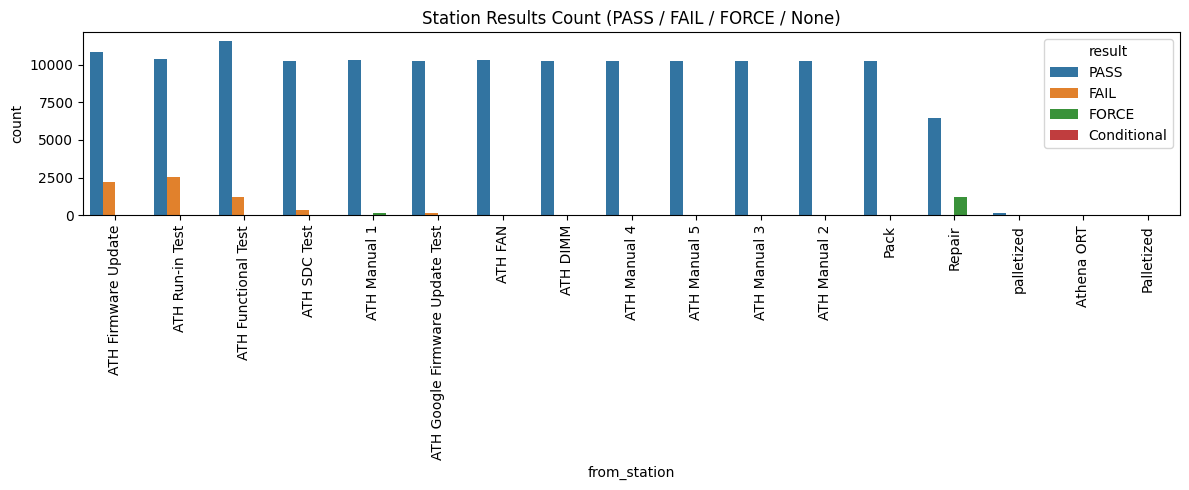

In [21]:

# ========== Bar Plot: Station Result Count ==========
plt.figure(figsize=(12, 5))
sns.countplot(data=df[df["result"].notna()], x="from_station", hue="result", order=df["from_station"].value_counts().index)
plt.xticks(rotation=90)
plt.title("Station Results Count (PASS / FAIL / FORCE / None)")
plt.tight_layout()
plt.show()


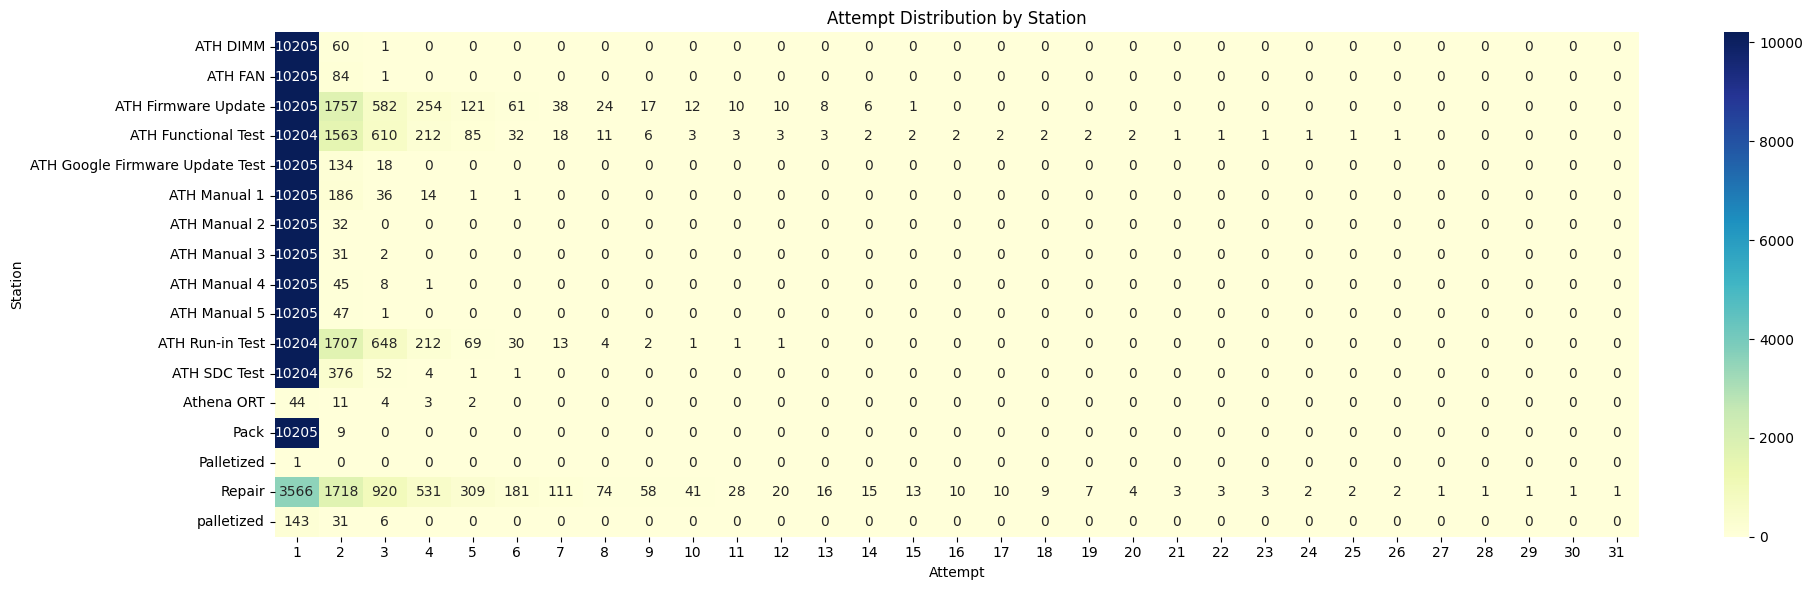

In [22]:

# ========== Heatmap: Attempt Count by Station ==========
attempt_summary = df.groupby(["from_station", "attempt"]).size().unstack(fill_value=0)
plt.figure(figsize=(20, 6))
sns.heatmap(attempt_summary, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Attempt Distribution by Station")
plt.xlabel("Attempt")
plt.ylabel("Station")
plt.tight_layout()
plt.show()


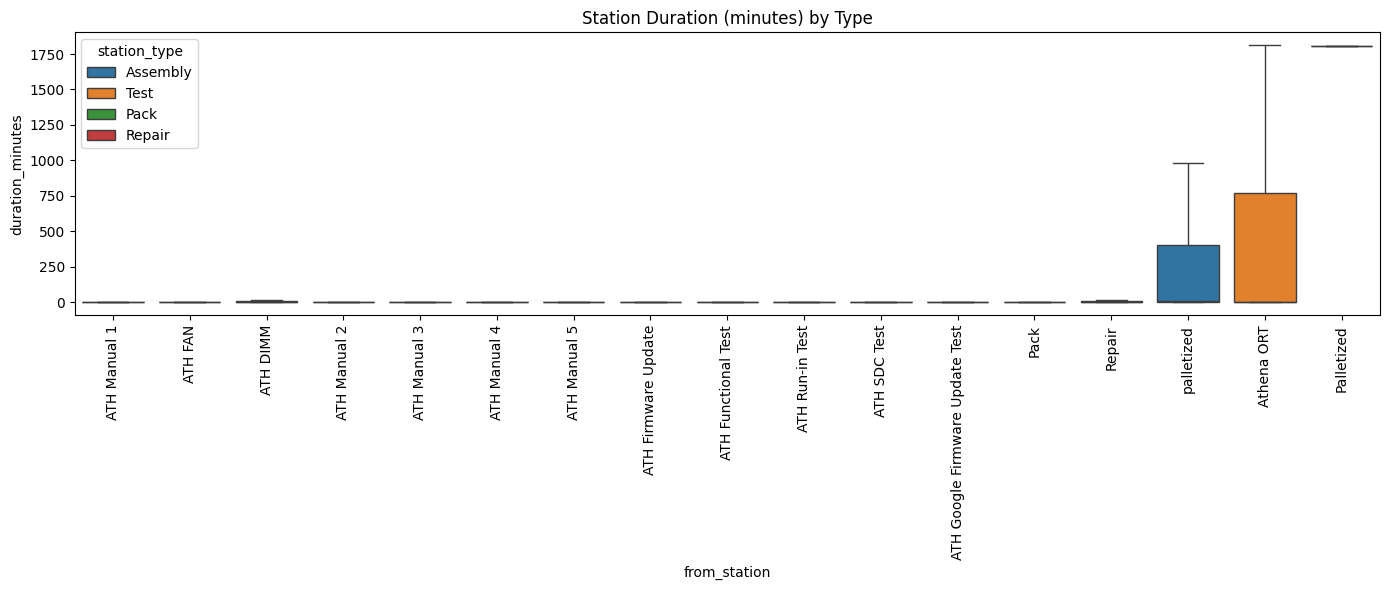

In [23]:

# ========== Boxplot: Duration by Station Type ==========
df["duration_minutes"] = (pd.to_datetime(df["out_station_time"]) - pd.to_datetime(df["in_station_time"])).dt.total_seconds() / 60
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[df["out_station_time"].notna()],
            x="from_station", y="duration_minutes", hue="station_type", showfliers=False)
plt.xticks(rotation=90)
plt.title("Station Duration (minutes) by Type")
plt.tight_layout()
plt.show()





# 🔧 Production Assembly Traceability: Analysis & Metrics Brainstorm

## Overview
We’re analyzing the full traceability and efficiency of a serial-number-based manufacturing flow. Key characteristics:

- **Serial Number** = Final unit with release → pack & ship info  
- **Model IDs** = Components within serial, Mobo/Agora assembled in **L6**, then send to **L10** to assemble with Gulp and other components
- **Logs** available for:
  - L6 (detailed: route/line/station)
  - L10 (simplified: station-level)
  - Mobo/Agora/Gulp/Athena GA Boards (separate log)
- Each log entry includes:
  - From/To station (and sometimes line/route)
  - In/Out time
  - Shift, result, station type, attempt count

---

## Key Analysis & Metrics

### 1. End-to-End Cycle Time
- Serial-level: `Pack & Ship Date - Release Date`
- Component-level:
  - L6 start → L10 end
- Break down by:
  - Model ID
  - Station / Route
  - Shift
  - Result & Attempts

---

### 2. Station-Level Process Metrics
- Time spent at each station = `Out Time - In Time`
- Metrics:
  - Mean, Median, Std Dev
  - Identify slow stations (bottlenecks)
  - Compare between L6/L10 groups

---

### 3. Yield & Retest Rates
- First Pass Yield (FPY) = % passed in 1 attempt
- Reassemble/Retest rate = % with `attempt_count > 1`
- Final Yield = Total pass / total processed
- By:
  - Station / Shift
  - Model ID
  - L6 vs L10

---

### 4. Shift-Based Efficiency
- Compare:
  - Cycle times
  - FPY / Retest rate
  - Blockage events (long in-station durations)
- Identify underperforming shifts or imbalances

---

### 5. Component Dependency & Delay
- Time from L6 Group complete → L10 Group start
- Join logs across A→B to quantify delay
- Insight into WIP queueing or supply wait

---

### 6. Final Integration Readiness
- For each serial:
  - Time all components (model_id) completed → Final L10 log
  - Indicates readiness gap / assembly wait time

---

### 7. Process Flow Consistency
- Validate expected station/route sequences
- Identify:
  - Missing steps
  - Unexpected rework loops
  - Process deviations

---

## Visualization Ideas
- Gantt chart per serial to show timeline  
- Sankey diagram: Component flow → Final assembly  
- Heatmap: Station vs Shift (FPY, cycle time)  
- Boxplot: Station cycle time distribution  

---

## Advanced Ideas (Future ML Applications)
- **Cycle Time Prediction** per unit/station  
- **Failure Prediction** based on logs & attempts  
- **Anomaly Detection**:
  - Outlier station times
  - Suspiciously high retest loops  
- **Clustering**:
  - Flow behavior types
  - Shift or model-specific patterns


In [16]:
sn_wo_model_df[sn_wo_model_df["serial_number"] == "FWI2516-14432"]

,workorder_id,serial_number,pack_date,ship_date,skuno,sap_create_date,sap_release_date,target_qty,finished_qty,model_usage,days_to_pack,days_to_ship
9640,000007010384,FWI2516-14432,2025-04-30 16:45:55,2025-05-08 20:14:57,1178143,2025-04-15 07:42:42-05:00,2025-04-16 07:53:36,200,200,"[{'model_id': '1176301', 'required_qty': 200},...",14.369664,22.514826


In [260]:
sn_wo_model_df[['days_to_pack', 'days_to_ship']].describe()


,days_to_pack,days_to_ship
count,9885.000000,9885.000000
mean,12.704104,26.878768
std,13.131171,20.649315
min,2.489317,7.268576
25%,6.954097,14.440405
50%,9.149294,21.489942
75%,14.117616,31.345579
max,234.655127,236.927847


In [261]:
sn_wo_model_df.groupby('skuno')[['days_to_pack', 'days_to_ship']].agg(['mean', 'std', 'count']).round(2)

days_to_pack              days_to_ship             
                mean    std count         mean    std count
skuno                                                      
1176298        13.32  14.49   926        39.52  37.80   926
1176304        11.56  12.65  3125        22.50  15.67  3125
1178139        12.92  12.43  4995        26.57  16.16  4995
1178143        15.10  16.67   826        30.79  26.84   826
1205593        10.95   0.60    13        47.09   0.00    13

In [262]:
sn_wo_model_df.skuno.unique()

array(['1176304', '1178139', '1176298', '1178143', '1205593'],
      dtype=object)

In [263]:
sn_wo_model_df.groupby('workorder_id')['days_to_ship'].mean().sort_values(ascending=False).head(10)

workorder_id
000007008639    89.181204
000007008644    88.351562
000007008536    79.724802
000007010759    55.306182
000007008310    52.689424
000007008115    48.622612
000007009281    47.086296
000007007886    43.896806
000007008139    42.099548
000007011141    41.164306
Name: days_to_ship, dtype: float64

In [264]:
sn_wo_model_df['release_week'] = sn_wo_model_df['sap_release_date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_avg_ship = sn_wo_model_df.groupby('release_week')['days_to_ship'].mean().reset_index()
weekly_avg_ship

,release_week,days_to_ship
0,2024-09-09,40.536273
1,2024-09-16,25.766997
2,2024-09-23,17.524309
3,2024-09-30,37.590430
4,2024-10-07,39.205834
5,2024-11-04,39.181734
6,2024-11-11,26.059386
7,2024-11-18,27.260245
8,2024-11-25,32.632383
9,2024-12-02,29.616538


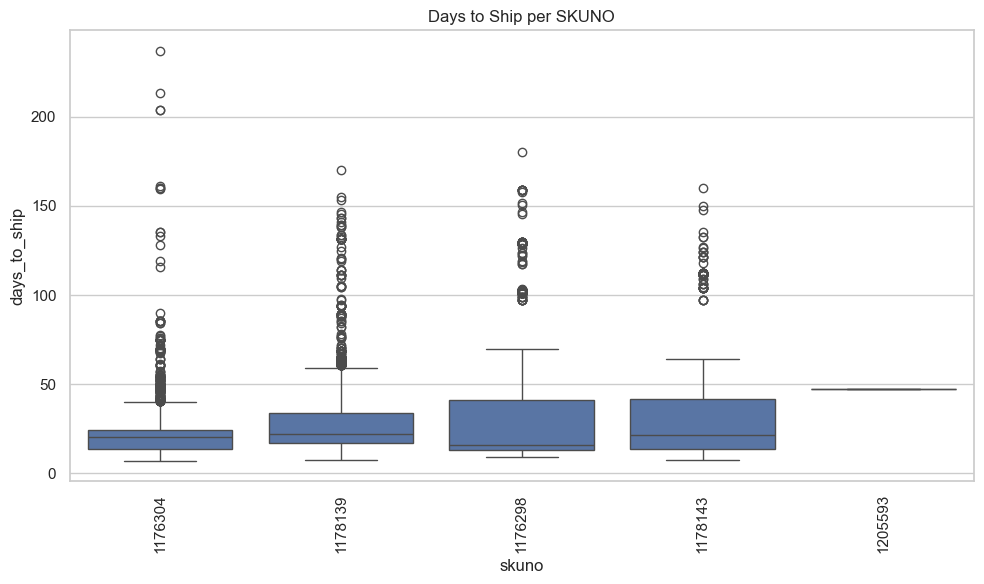

In [265]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=sn_wo_model_df, x='skuno', y='days_to_ship')
plt.xticks(rotation=90)
plt.title("Days to Ship per SKUNO")
plt.tight_layout()
plt.show()


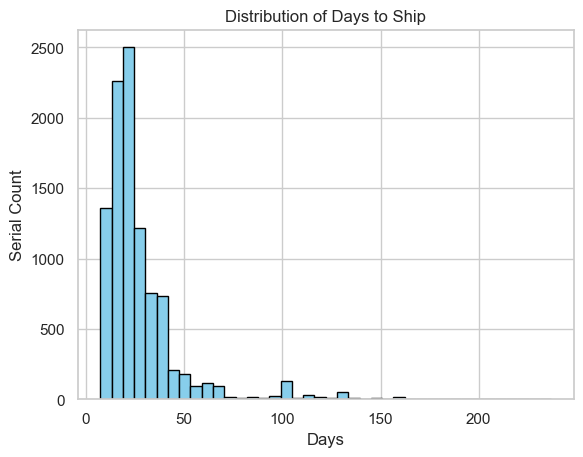

In [266]:
plt.hist(sn_wo_model_df['days_to_ship'], bins=40, color='skyblue', edgecolor='black')
plt.title("Distribution of Days to Ship")
plt.xlabel("Days")
plt.ylabel("Serial Count")
plt.grid(True)
plt.show()


In [267]:
sn_wo_model_df.groupby('workorder_id')['days_to_ship'].std().sort_values(ascending=False).head(10)


workorder_id
000007008310    43.361367
000007008337    41.207245
000007007886    33.644352
000007008536    33.408637
000007007366    32.351757
000007007788    31.724360
000007008115    31.599061
000007007986    29.286181
000007008276    28.889370
000007007902    27.047887
Name: days_to_ship, dtype: float64

In [268]:
# Explode model_usage: one row per (workorder_id, model_id, required_qty)
wo_model_exploded = (
    sn_wo_model_df[['workorder_id', 'skuno', 'target_qty', 'model_usage']]
    .drop_duplicates('workorder_id')
    .explode('model_usage')
    .dropna()
)
wo_model_exploded['model_id'] = wo_model_exploded['model_usage'].apply(lambda x: x['model_id'])
wo_model_exploded['required_qty'] = wo_model_exploded['model_usage'].apply(lambda x: x['required_qty'])
wo_model_exploded.drop('model_usage', axis=1, inplace=True)

# Merge WO-level average ship time
wo_ship_time = sn_wo_model_df.groupby('workorder_id')['days_to_ship'].mean().reset_index()
wo_model_exploded = wo_model_exploded.merge(wo_ship_time, on='workorder_id', how='left')


In [270]:
wo_model_exploded['total_qty'] = wo_model_exploded['required_qty'] * wo_model_exploded['target_qty']
wo_model_exploded.groupby('model_id')['total_qty'].sum().sort_values(ascending=False).head(20)


model_id
1152063-01    16435540
1158756-01    12653480
1145816-01    12647240
1114467       10955692
1066991-01    10955692
1145896        9650680
07087259       8216769
1152012        6976731
1153179-01     6810800
1183521        5728372
1132967-02     5477846
1117005        5477846
1145817-01     3034020
1152066-01     2848000
1131563-04     2738923
1149921        2738923
1138896-04     2738923
1176301        2738923
1158204-01     2738923
1156008        2738923
Name: total_qty, dtype: int64

In [271]:
wo_model_exploded.groupby('model_id')['days_to_ship'].mean().sort_values(ascending=False).head(20)


model_id
1206836-01     89.181204
1206837-01     88.351562
1153180-01     55.306182
1204621        47.086296
1203451-01     47.086296
1195398-01     41.164306
1152063-01     39.771030
1217562-01     39.195331
1129195-FLG    38.993066
1169328        36.751665
1116344        34.813673
1139545        34.813673
1160607-01     34.813673
1178297        34.813673
1158752-01     34.514741
1178141        32.093918
07009507       32.069149
1183439        30.922384
1129195        29.937716
1114467        29.580674
Name: days_to_ship, dtype: float64

In [272]:
wo_model_exploded.groupby('model_id')['days_to_ship'].std().sort_values(ascending=False).head(20)


model_id
1152063-01     26.689843
1217562-01     22.784185
1129195-FLG    21.080087
1169328        20.503828
1178141        18.565483
07009507       17.299434
1116344        16.970045
1139545        16.970045
1178297        16.970045
1160607-01     16.970045
1183439        16.843962
1114467        15.771973
07087259       15.771973
07002344       15.771973
07001541       15.771973
1183521        15.771973
1179319        15.771973
1132967-02     15.771973
1138896-04     15.771973
1117005        15.771973
Name: days_to_ship, dtype: float64

In [24]:
top_models = (
    wo_model_exploded
    .groupby('model_id')['total_qty']
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .reset_index()
)

plt.figure(figsize=(10,5))
sns.barplot(data=top_models, x='model_id', y='total_qty')
plt.xticks(rotation=45)
plt.title("Top 15 Most Used SKUs (Qty Weighted)")
plt.ylabel("Total Required Qty")
plt.tight_layout()
plt.show()


NameError: name 'wo_model_exploded' is not defined

In [115]:

# Identify SNs packed and retested
pack_retest_sn = athena_shipped_sn_log_final_df[athena_shipped_sn_log_final_df["station"] == "Pack"].serial_number.unique()
df = athena_shipped_sn_log_final_df[~athena_shipped_sn_log_final_df["serial_number"].isin(pack_retest_sn)].copy()

# Calculate time spent at current station = next entry time - current time
df["next_time"] = df.groupby("serial_number")["in_station_time"].shift(-1)
df["duration_minutes"] = (df["next_time"] - df["in_station_time"]).dt.total_seconds() / 60

# Optional: round for readability
df["duration_minutes"] = df["duration_minutes"].round(1)

# Step 2: Summary statistics per station
station_summary = df.groupby("station")["duration_minutes"].describe().round(1)

# Step 3: Serial number scoring
sn_score = df.groupby("serial_number").agg(
    total_time=("duration_minutes", "sum"),
    mean_time=("duration_minutes", "mean"),
    num_stations=("station", "nunique"),
    num_logs=("station", "count")
).reset_index().round(1)

# Step 4: Count repeated station visits
repeated_station_counts = (
    df.groupby(["serial_number", "station"])
    .size()
    .reset_index(name="visits")
    .query("visits > 1")
    .groupby("serial_number")
    .size()
    .reset_index(name="repeated_stations")
)

# Merge repeated station info into sn_score
sn_score = sn_score.merge(repeated_station_counts, on="serial_number", how="left")
sn_score["repeated_stations"] = sn_score["repeated_stations"].fillna(0).astype(int)

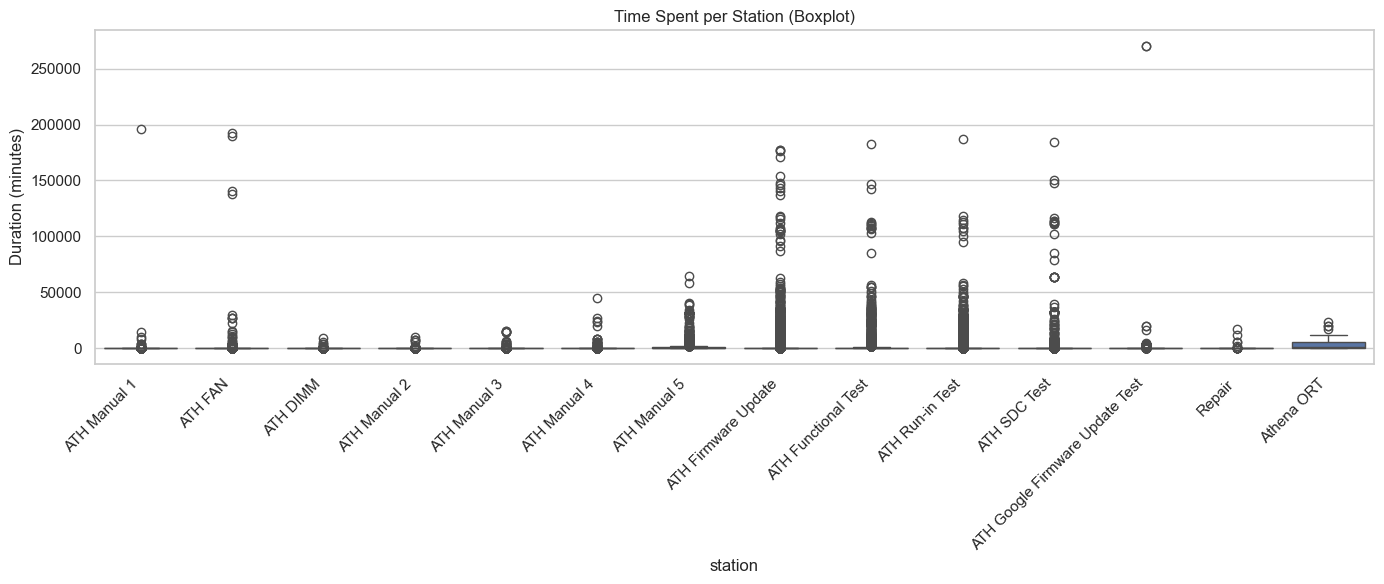

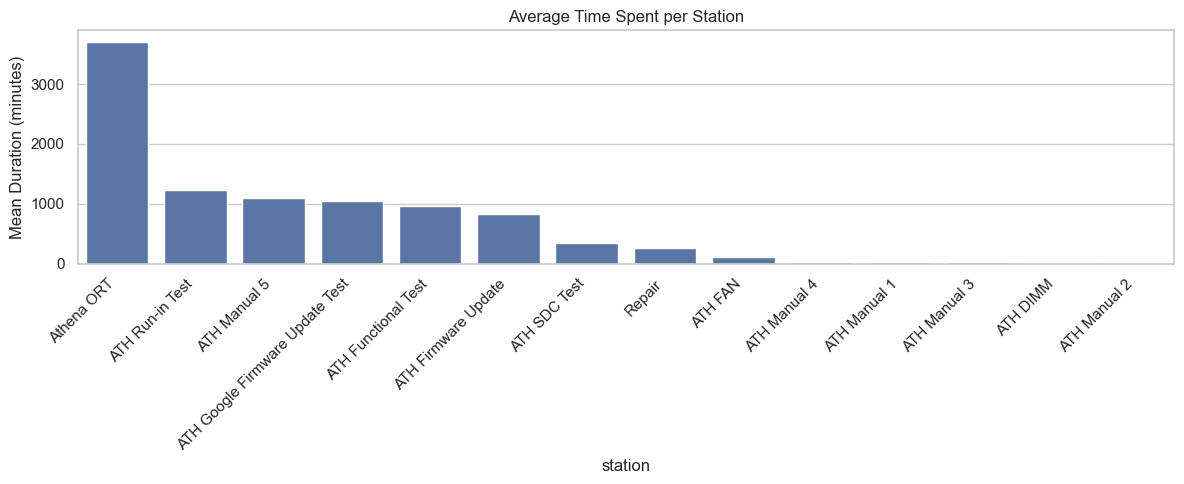

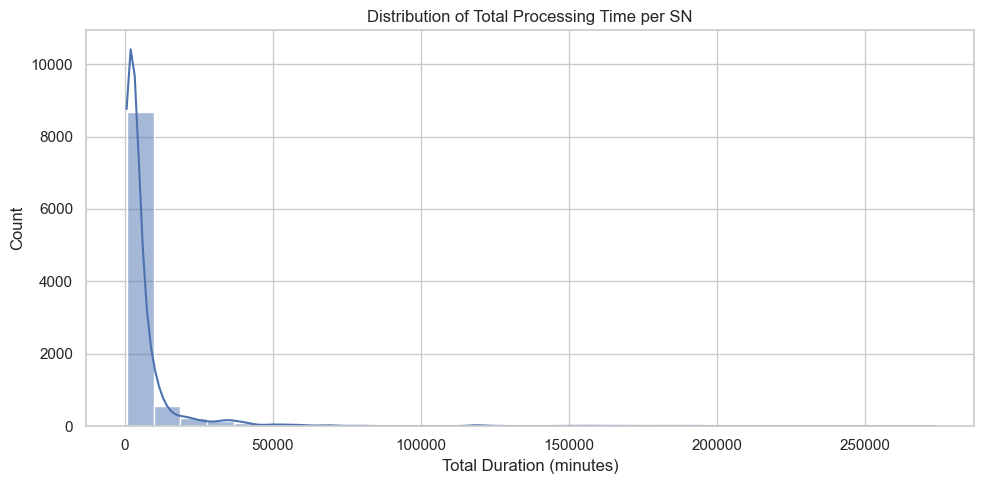

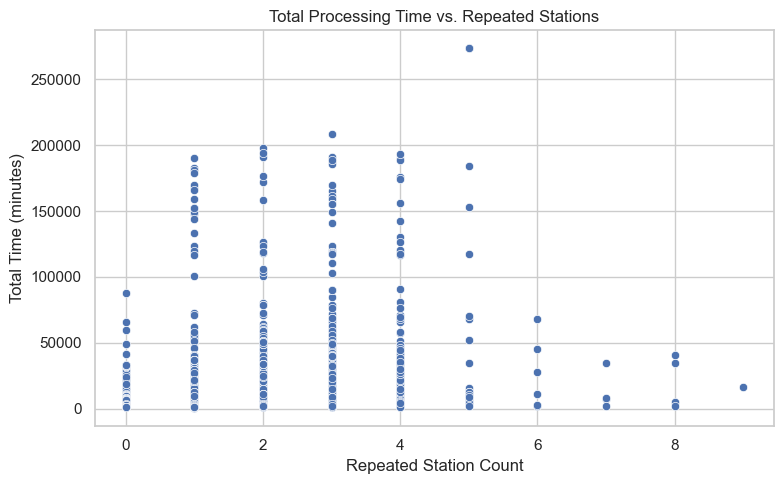

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set(style="whitegrid")

# 1. Boxplot of duration per station (highlight variability and outliers)
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="station", y="duration_minutes")
plt.xticks(rotation=45, ha='right')
plt.title("Time Spent per Station (Boxplot)")
plt.ylabel("Duration (minutes)")
plt.tight_layout()
plt.show()

# 2. Top stations by mean delay (bar chart)
station_mean_delay = df.groupby("station")["duration_minutes"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x=station_mean_delay.index, y=station_mean_delay.values)
plt.xticks(rotation=45, ha='right')
plt.title("Average Time Spent per Station")
plt.ylabel("Mean Duration (minutes)")
plt.tight_layout()
plt.show()

# 3. Histogram of total time per SN
plt.figure(figsize=(10, 5))
sns.histplot(sn_score["total_time"], bins=30, kde=True)
plt.title("Distribution of Total Processing Time per SN")
plt.xlabel("Total Duration (minutes)")
plt.tight_layout()
plt.show()

# 4. Scatterplot: total time vs repeated stations
plt.figure(figsize=(8, 5))
sns.scatterplot(data=sn_score, x="repeated_stations", y="total_time")
plt.title("Total Processing Time vs. Repeated Stations")
plt.xlabel("Repeated Station Count")
plt.ylabel("Total Time (minutes)")
plt.tight_layout()
plt.show()



In [108]:
athena_shipped_sn_log_final_df.station.value_counts()

station
ATH Firmware Update                15943
ATH Functional Test                14678
ATH Run-in Test                    14151
ATH SDC Test                       11194
ATH Google Firmware Update Test    10584
ATH Manual 1                        9930
ATH FAN                             9920
ATH DIMM                            9873
ATH Manual 2                        9873
ATH Manual 3                        9871
ATH Manual 4                        9863
ATH Manual 5                        9863
Repair                               173
Athena ORT                            42
Pack                                   1
Name: count, dtype: int64

Conclustion from plots:
1. Time Spent per Station (Boxplot)
   * **Observation:** A few stations like **ATH Firmware Update**, **ATH Functional Test**, **ATH Run-in Test**, and **ATH SDC Test** show a wide spread with extreme outliers — some durations over 100,000+ minutes (≈ 70 days).
   * **Conclusion:** These are likely bottlenecks or problematic stations with long queue times, test retries, or handling delays. Investigate SNs with extreme values at these stations.
2. Mean Duration per Station (Bar Chart)
   * **Observation:** **Athena ORT** stands out with very high mean duration. It may not appear often but when it does, it consumes a huge amount of time.
   * **Conclusion:** A rare but very time-consuming step. Investigate whether it's expected (e.g., a long-running soak test), or a symptom of rework/retest/holding.
3. SN Total Processing Time Distribution
    * **Observation:** Strong right-skew. Most SNs complete within a reasonable range, but a long tail of slow ones.
    * **Conclusion:** Ideal for outlier flagging. You can define alerts for SNs above the 95th percentile total time.
4.  Processing Time vs. Repeated Stations
    * **Observation:** SNs with repeated station visits often have higher processing times.
    * **Conclusion:** Back-and-forth behavior hurts efficiency. These SNs may involve retries or repair loops. Track which station pairs cause loops (e.g., Functional Test → Repair → Functional Test).